## 2.2 PyTorch第一步

PyTorch的简洁设计使得它入门很简单，在深入介绍PyTorch之前，本节将先介绍一些PyTorch的基础知识，使得读者能够对PyTorch有一个大致的了解，并能够用PyTorch搭建一个简单的神经网络。部分内容读者可能暂时不太理解，可先不予以深究，本书的第3章和第4章将会对此进行深入讲解。

本节内容参考了PyTorch官方教程[^1]并做了相应的增删修改，使得内容更贴合新版本的PyTorch接口，同时也更适合新手快速入门。另外本书需要读者先掌握基础的Numpy使用，其他相关知识推荐读者参考CS231n的教程[^2]。

[^1]: http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
[^2]: http://cs231n.github.io/python-numpy-tutorial/

### Tensor

Tensor是PyTorch中重要的数据结构，可认为是一个高维数组。它可以是一个数（标量）、一维数组（向量）、二维数组（矩阵）以及更高维的数组。Tensor和Numpy的ndarrays类似，但Tensor可以使用GPU进行加速。Tensor的使用和Numpy及Matlab的接口十分相似，下面通过几个例子来看看Tensor的基本使用。

In [6]:
 from __future__ import print_function
import torch as t
t.__version__

'1.7.1'

In [ ]:
# 构建 5x3 矩阵，只是分配了空间，未初始化
x = t.Tensor(5, 3)

x = t.Tensor([[1,2],[3,4]])
x

In [ ]:
# 使用[0,1]均匀分布随机初始化二维数组
x = t.rand(5, 3)  
x

In [ ]:
print(x.size()) # 查看x的形状
x.size()[1], x.size(1) # 查看列的个数, 两种写法等价

`torch.Size` 是tuple对象的子类，因此它支持tuple的所有操作，如x.size()[0]

In [ ]:
y = t.rand(5, 3)
# 加法的第一种写法
x + y

In [ ]:
# 加法的第二种写法
t.add(x, y)

In [ ]:
# 加法的第三种写法：指定加法结果的输出目标为result
result = t.Tensor(5, 3) # 预先分配空间
t.add(x, y, out=result) # 输入到result
result

In [ ]:
print('最初y')
print(y)

print('第一种加法，y的结果')
y.add(x) # 普通加法，不改变y的内容
print(y)

print('第二种加法，y的结果')
y.add_(x) # inplace 加法，y变了
print(y)

注意，函数名后面带下划线**`_`** 的函数会修改Tensor本身。例如，`x.add_(y)`和`x.t_()`会改变 `x`，但`x.add(y)`和`x.t()`返回一个新的Tensor， 而`x`不变。

In [ ]:
# Tensor的选取操作与Numpy类似
x[:, 1]

Tensor还支持很多操作，包括数学运算、线性代数、选择、切片等等，其接口设计与Numpy极为相似。更详细的使用方法，会在第三章系统讲解。

Tensor和Numpy的数组之间的互操作非常容易且快速。对于Tensor不支持的操作，可以先转为Numpy数组处理，之后再转回Tensor。c



In [ ]:
a = t.ones(5) # 新建一个全1的Tensor
a

In [ ]:
b = a.numpy() # Tensor -> Numpy
b

In [ ]:
import numpy as np
a = np.ones(5)
b = t.from_numpy(a) # Numpy->Tensor
print(a)
print(b) 

Tensor和numpy对象共享内存，所以他们之间的转换很快，而且几乎不会消耗什么资源。但这也意味着，如果其中一个变了，另外一个也会随之改变。

In [ ]:
b.add_(1) # 以`_`结尾的函数会修改自身
print(a)
print(b) # Tensor和Numpy共享内存

如果你想获取某一个元素的值，可以使用`scalar.item`。 直接`tensor[idx]`得到的还是一个tensor: 一个0-dim 的tensor，一般称为scalar.

In [ ]:
scalar = b[0]
scalar

In [ ]:
scalar.size() #0-dim

In [ ]:
scalar.item() # 使用scalar.item()能从中取出python对象的数值

In [ ]:
tensor = t.tensor([2]) # 注意和scalar的区别
tensor,scalar
tensor.type

In [ ]:
tensor.size(),scalar.size()

In [ ]:
# 只有一个元素的tensor也可以调用`tensor.item()`
tensor.item(), scalar.item()

此外在pytorch中还有一个和`np.array` 很类似的接口: `torch.tensor`, 二者的使用十分类似。

In [ ]:
tensor = t.tensor([3,4]) # 新建一个包含 3，4 两个元素的tensor

In [ ]:
scalar = t.tensor(3)
scalar

In [ ]:
old_tensor = tensor
new_tensor = old_tensor.clone()
new_tensor[0] = 1111
old_tensor, new_tensor

需要注意的是，`t.tensor()`或者`tensor.clone()`总是会进行数据拷贝，新tensor和原来的数据不再共享内存。所以如果你想共享内存的话，建议使用`torch.from_numpy()`或者`tensor.detach()`来新建一个tensor, 二者共享内存。

In [ ]:
new_tensor = old_tensor.detach()
new_tensor[0] = 1111
old_tensor, new_tensor

Tensor可通过`.cuda` 方法转为GPU的Tensor，从而享受GPU带来的加速运算。

In [ ]:
# 在不支持CUDA的机器下，下一步还是在CPU上运行
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
x = x.to(device)
y = y.to(x.device)
z = x+y

此外，还可以使用`tensor.cuda()` 的方式将tensor拷贝到gpu上，但是这种方式不太推荐。

此处可能发现GPU运算的速度并未提升太多，这是因为x和y太小且运算也较为简单，而且将数据从内存转移到显存还需要花费额外的开销。GPU的优势需在大规模数据和复杂运算下才能体现出来。


### autograd: 自动微分

深度学习的算法本质上是通过反向传播求导数，而PyTorch的**`autograd`**模块则实现了此功能。在Tensor上的所有操作，autograd都能为它们自动提供微分，避免了手动计算导数的复杂过程。
 
~~`autograd.Variable`是Autograd中的核心类，它简单封装了Tensor，并支持几乎所有Tensor有的操作。Tensor在被封装为Variable之后，可以调用它的`.backward`实现反向传播，自动计算所有梯度~~ ~~Variable的数据结构如图2-6所示。~~


![图2-6:Variable的数据结构](imgs/autograd_Variable.svg)

  *从0.4起, Variable 正式合并入Tensor, Variable 本来实现的自动微分功能，Tensor就能支持。读者还是可以使用Variable(tensor), 但是这个操作其实什么都没做。建议读者以后直接使用tensor*. 
  
  要想使得Tensor使用autograd功能，只需要设置`tensor.requries_grad=True`. 


~~Variable主要包含三个属性。~~
~~- `data`：保存Variable所包含的Tensor~~
~~- `grad`：保存`data`对应的梯度，`grad`也是个Variable，而不是Tensor，它和`data`的形状一样。~~
~~- `grad_fn`：指向一个`Function`对象，这个`Function`用来反向传播计算输入的梯度，具体细节会在下一章讲解。~~

In [ ]:
# 为tensor设置 requires_grad 标识，代表着需要求导数
# pytorch 会自动调用autograd 记录操作
x = t.ones(2, 2, requires_grad=True)

# 上一步等价于
# x = t.ones(2,2)
# x.requires_grad = True

x

In [ ]:
y = x.sum()
y

In [ ]:
y.grad_fn

In [ ]:
y.backward() # 反向传播,计算梯度

In [ ]:
# y = x.sum() = (x[0][0] + x[0][1] + x[1][0] + x[1][1])
# 每个值的梯度都为1
x.grad 

注意：`grad`在反向传播过程中是累加的(accumulated)，这意味着每一次运行反向传播，梯度都会累加之前的梯度，所以反向传播之前需把梯度清零。

In [ ]:
y.backward()
x.grad

In [ ]:
y.backward()
x.grad

In [ ]:
# 以下划线结束的函数是inplace操作，会修改自身的值，就像add_
x.grad.data.zero_()

In [ ]:
y.backward()
x.grad

###  神经网络

Autograd实现了反向传播功能，但是直接用来写深度学习的代码在很多情况下还是稍显复杂，torch.nn是专门为神经网络设计的模块化接口。nn构建于 Autograd之上，可用来定义和运行神经网络。nn.Module是nn中最重要的类，可把它看成是一个网络的封装，包含网络各层定义以及forward方法，调用forward(input)方法，可返回前向传播的结果。下面就以最早的卷积神经网络：LeNet为例，来看看如何用`nn.Module`实现。LeNet的网络结构如图2-7所示。

![图2-7:LeNet网络结构](imgs/nn_lenet.png)

这是一个基础的前向传播(feed-forward)网络: 接收输入，经过层层传递运算，得到输出。

#### 定义网络

定义网络时，需要继承`nn.Module`，并实现它的forward方法，把网络中具有可学习参数的层放在构造函数`__init__`中。如果某一层(如ReLU)不具有可学习的参数，则既可以放在构造函数中，也可以不放，但建议不放在其中，而在forward中使用`nn.functional`代替。

In [1]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        # 下式等价于nn.Module.__init__(self)
        super(Net, self).__init__()
        
        # 卷积层 '1'表示输入图片为单通道, '6'表示输出通道数，'5'表示卷积核为5*5
        self.conv1 = nn.Conv2d(1, 6, 5) 
        # 卷积层
        self.conv2 = nn.Conv2d(6, 16, 5) 
        # 仿射层/全连接层，y = Wx + b
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        # 卷积 -> 激活 -> 池化 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        # reshape，‘-1’表示自适应
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


只要在nn.Module的子类中定义了forward函数，backward函数就会自动被实现(利用`autograd`)。在`forward` 函数中可使用任何tensor支持的函数，还可以使用if、for循环、print、log等Python语法，写法和标准的Python写法一致。

网络的可学习参数通过`net.parameters()`返回，`net.named_parameters`可同时返回可学习的参数及名称。

In [2]:
params = list(net.parameters())
print(len(params))

10


In [3]:
for name,parameters in net.named_parameters():
    print(name,':',parameters.size())

conv1.weight : torch.Size([6, 1, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


forward函数的输入和输出都是Tensor。

In [7]:
input = t.randn(1, 1, 32, 32)
out = net(input)
out.size()

torch.Size([1, 10])

In [8]:
net.zero_grad() # 所有参数的梯度清零
out.backward(t.ones(1,10)) # 反向传播

需要注意的是，torch.nn只支持mini-batches，不支持一次只输入一个样本，即一次必须是一个batch。但如果只想输入一个样本，则用 `input.unsqueeze(0)`将batch_size设为１。例如 `nn.Conv2d` 输入必须是4维的，形如$nSamples \times nChannels \times Height \times Width$。可将nSample设为1，即$1 \times nChannels \times Height \times Width$。

#### 损失函数

nn实现了神经网络中大多数的损失函数，例如nn.MSELoss用来计算均方误差，nn.CrossEntropyLoss用来计算交叉熵损失。

In [9]:
output = net(input)
target = t.arange(0,10).view(1,10).float() 
criterion = nn.MSELoss()
loss = criterion(output, target)
loss # loss是个scalar

tensor(28.3020, grad_fn=<MseLossBackward>)

如果对loss进行反向传播溯源(使用`gradfn`属性)，可看到它的计算图如下：

```
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d  
      -> view -> linear -> relu -> linear -> relu -> linear 
      -> MSELoss
      -> loss
```

当调用`loss.backward()`时，该图会动态生成并自动微分，也即会自动计算图中参数(Parameter)的导数。

In [10]:
# 运行.backward，观察调用之前和调用之后的grad
net.zero_grad() # 把net中所有可学习参数的梯度清零
print('反向传播之前 conv1.bias的梯度')
print(net.conv1.bias.grad)
loss.backward()
print('反向传播之后 conv1.bias的梯度')
print(net.conv1.bias.grad)

反向传播之前 conv1.bias的梯度
tensor([0., 0., 0., 0., 0., 0.])
反向传播之后 conv1.bias的梯度
tensor([ 0.0106,  0.0003,  0.0128, -0.0428,  0.0006,  0.0033])


#### 优化器

在反向传播计算完所有参数的梯度后，还需要使用优化方法来更新网络的权重和参数，例如随机梯度下降法(SGD)的更新策略如下：
```
weight = weight - learning_rate * gradient
```

手动实现如下：

```python
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)# inplace 减法
```

`torch.optim`中实现了深度学习中绝大多数的优化方法，例如RMSProp、Adam、SGD等，更便于使用，因此大多数时候并不需要手动写上述代码。

In [11]:
import torch.optim as optim
#新建一个优化器，指定要调整的参数和学习率
optimizer = optim.SGD(net.parameters(), lr = 0.01)

# 在训练过程中
# 先梯度清零(与net.zero_grad()效果一样)
optimizer.zero_grad() 

# 计算损失
output = net(input)
loss = criterion(output, target)

#反向传播
loss.backward()

#更新参数
optimizer.step()



####  数据加载与预处理

在深度学习中数据加载及预处理是非常复杂繁琐的，但PyTorch提供了一些可极大简化和加快数据处理流程的工具。同时，对于常用的数据集，PyTorch也提供了封装好的接口供用户快速调用，这些数据集主要保存在torchvison中。

`torchvision`实现了常用的图像数据加载功能，例如Imagenet、CIFAR10、MNIST等，以及常用的数据转换操作，这极大地方便了数据加载，并且代码具有可重用性。


### 小试牛刀：CIFAR-10分类

下面我们来尝试实现对CIFAR-10数据集的分类，步骤如下: 

1. 使用torchvision加载并预处理CIFAR-10数据集
2. 定义网络
3. 定义损失函数和优化器
4. 训练网络并更新网络参数
5. 测试网络

####   CIFAR-10数据加载及预处理

CIFAR-10[^3]是一个常用的彩色图片数据集，它有10个类别: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'。每张图片都是$3\times32\times32$，也即3-通道彩色图片，分辨率为$32\times32$。

[^3]: http://www.cs.toronto.edu/~kriz/cifar.html

In [12]:
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor转成Image，方便可视化

In [22]:
# 第一次运行程序torchvision会自动下载CIFAR-10数据集，
# 大约100M，需花费一定的时间，
# 如果已经下载有CIFAR-10，可通过root参数指定

# 定义对数据的预处理
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])

# 训练集
trainset = tv.datasets.CIFAR10(
                    'data/', 
                    train=True, 
                    download=True,
                    transform=transform)

trainloader = t.utils.data.DataLoader(
                    trainset, 
                    batch_size=4,
                    shuffle=True, 
                    num_workers=2)



Using downloaded and verified file: data/cifar-10-python.tar.gz
Extracting data/cifar-10-python.tar.gz to data/


In [23]:
# 测试集
testset = tv.datasets.CIFAR10(
                    'data/',
                    train=False, 
                    download=True, 
                    transform=transform)

testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size=4, 
                    shuffle=False,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Dataset对象是一个数据集，可以按下标访问，返回形如(data, label)的数据。

ship


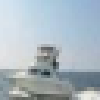

In [24]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

Dataloader是一个可迭代的对象，它将dataset返回的每一条数据拼接成一个batch，并提供多线程加速优化和数据打乱等操作。当程序对dataset的所有数据遍历完一遍之后，相应的对Dataloader也完成了一次迭代。

        car        frog         car        ship


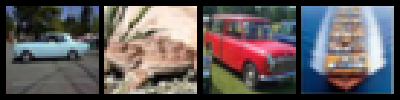

In [25]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

####   定义网络

拷贝上面的LeNet网络，修改self.conv1第一个参数为3通道，因CIFAR-10是3通道彩图。

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


####  定义损失函数和优化器(loss和optimizer)

In [27]:
from torch import optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

###   训练网络

所有网络的训练流程都是类似的，不断地执行如下流程：

- 输入数据
- 前向传播+反向传播
- 更新参数


In [28]:
t.set_num_threads(8)
for epoch in range(2):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # 输入数据
        inputs, labels = data
        
        # 梯度清零
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.248
[1,  4000] loss: 1.878
[1,  6000] loss: 1.656
[1,  8000] loss: 1.570
[1, 10000] loss: 1.508
[1, 12000] loss: 1.456
[2,  2000] loss: 1.414
[2,  4000] loss: 1.368
[2,  6000] loss: 1.323
[2,  8000] loss: 1.315
[2, 10000] loss: 1.275
[2, 12000] loss: 1.267
Finished Training


此处仅训练了2个epoch（遍历完一遍数据集称为一个epoch），来看看网络有没有效果。将测试图片输入到网络中，计算它的label，然后与实际的label进行比较。

实际的label:       cat     ship     ship    plane


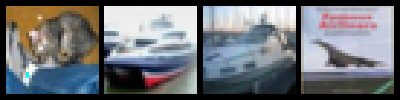

In [29]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
print('实际的label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))


接着计算网络预测的label：

In [30]:
# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高的那个类
_, predicted = t.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(4)))

预测结果:    cat  ship   car plane


已经可以看出效果，准确率50%，但这只是一部分的图片，再来看看在整个测试集上的效果。

In [31]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with t.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))

10000张测试集中的准确率为: 55 %


训练的准确率远比随机猜测(准确率10%)好，证明网络确实学到了东西。

####  在GPU训练
就像之前把Tensor从CPU转到GPU一样，模型也可以类似地从CPU转到GPU。

In [34]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

net.to(device)
images = images.to(device)
labels = labels.to(device)
output = net(images)
loss= criterion(output,labels)

loss

tensor(0.7427, device='cuda:0', grad_fn=<NllLossBackward>)

如果发现在GPU上并没有比CPU提速很多，实际上是因为网络比较小，GPU没有完全发挥自己的真正实力。

对PyTorch的基础介绍至此结束。总结一下，本节主要包含以下内容。

1. Tensor: 类似Numpy数组的数据结构，与Numpy接口类似，可方便地互相转换。
2. autograd/: 为tensor提供自动求导功能。
3. nn: 专门为神经网络设计的接口，提供了很多有用的功能(神经网络层，损失函数，优化器等)。
4. 神经网络训练: 以CIFAR-10分类为例演示了神经网络的训练流程，包括数据加载、网络搭建、训练及测试。

通过本节的学习，相信读者可以体会出PyTorch具有接口简单、使用灵活等特点。从下一章开始，本书将深入系统地讲解PyTorch的各部分知识。